<a href="https://colab.research.google.com/github/kquijano/AG2PI/blob/main/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installing requirements

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 4.0 MB/s 
     |████████████████████████████████| 397 kB 16.8 MB/s 
     |████████████████████████████████| 829 kB 31.9 MB/s 
     |████████████████████████████████| 133 kB 58.9 MB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
     |████████████████████████████████| 952 kB 35.8 MB/s 
     |████████████████████████████████| 1.1 MB 30.3 MB/s 
     |████████████████████████████████| 271 kB 35.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 35.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=f7ca6d6e97656ee2977ac67c3655c4fc28a7224b15642366641c2d8b092ba1c1
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

# importing necessary packages

In [ ]:
from torchvision.datasets import VOCSegmentation
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from torchvision import transforms
from PIL import Image
from google.colab import drive
import os
import h5py

# Downloading and initializing VOC 2007 Segmentation dataset

In [ ]:
dataset = VOCSegmentation(root = ".", year = '2007', image_set= 'train', download = True)

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting ./VOCtrainval_06-Nov-2007.tar to .


# Visualizing an instance of this dataset

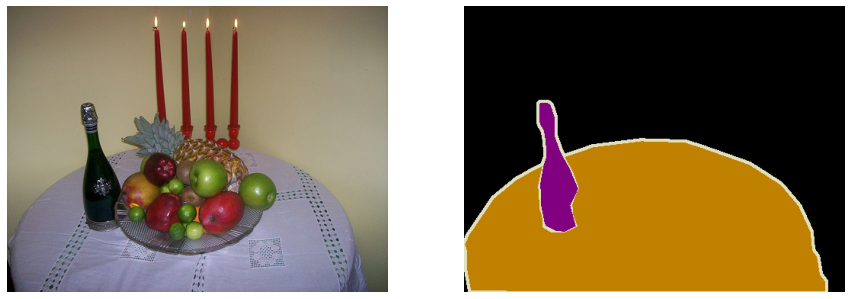

In [ ]:
image_index = 6

# img = Image.open(dataset.images[image_index])
# img = img.convert("RGB")
# mask = Image.open(dataset.masks[image_index])
# mask = mask.convert("RGB")

img, mask = dataset[image_index]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15,10)
ax1.axis('off')
ax2.axis('off')

ax1.imshow(img)
ax2.imshow(mask)

# Downloading Model

Downloading pretrained FCN-ResNet50 model from pytorch and run the sample image
through it to get the predictions on the semantic segmentation.

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

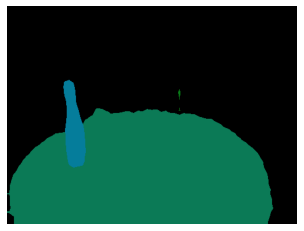

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_image = Image.open(dataset.images[image_index])
input_image = input_image.convert("RGB")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

plt.axis('off')
plt.imshow(r)

# Charcoal Dry Rot Segmentation
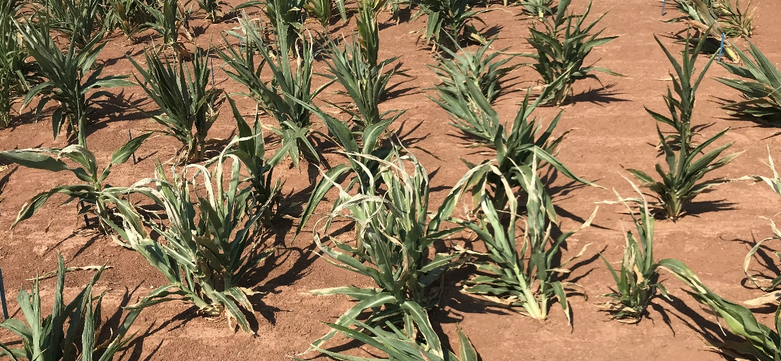

# Downloading dry rot data 
This is a sampled dataset from the images we have already labeled. Not running it now to save time.

In [ ]:
!wget https://data.cyverse.org/dav-anon/iplant/home/ariyanzarei/AG2PI.h5

--2022-02-18 19:23:00--  https://data.cyverse.org/dav-anon/iplant/home/ariyanzarei/AG2PI.h5
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.46
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2883588096 (2.7G) [application/octet-stream]
Saving to: ‘AG2PI.h5’

AG2PI.h5            100%[===================>]   2.69G  20.0MB/s    in 2m 40s  

2022-02-18 19:25:40 (17.2 MB/s) - ‘AG2PI.h5’ saved [2883588096/2883588096]



# Mounting Google Drive
Mounting my google drive to this colab disk in order to access the previously downloaded dataset.

In [ ]:
drive.mount('/content/drive')
!cp AG2PI.h5 /content/drive/MyDrive/.

Mounted at /content/drive


# Checking the existence of the file

In [ ]:
!du -sh drive/MyDrive/AG2PI.h5

2.7G	drive/MyDrive/AG2PI.h5


# Defining a dataset object for getting our data


In [ ]:
class SorghumDataset(torch.utils.data.Dataset):
    def __init__(self,sname,l=-1):
        super().__init__()
        self.set_name = sname
        self.length = l

    def __getitem__(self, index):
        f = h5py.File("/content/drive/MyDrive/AG2PI.h5",'r')
        x = f[f"X_{self.set_name}"][index]
        y = f[f"Y_{self.set_name}"][index]
        
        f.close()
        
        return torch.from_numpy(x).float().transpose(0,2).transpose(1,2),\
            torch.from_numpy(y).type(torch.LongTensor).transpose(0,2).transpose(1,2).squeeze()

        return input_image,input_mask

    def __len__(self):
        if self.length != -1:
            return self.length
        else:
            f = h5py.File("/content/drive/MyDrive/AG2PI.h5",'r')
            self.length = f[f"X_{self.set_name}"].shape[0]
            f.close()
            return self.length


# Defining a lightning wraper for the pretrained FCN-ResNet Model

In [ ]:
class FCN(pl.LightningModule):
        
    def __init__(self, hparams, backbn):
        '''
        Parameters
        ----------
        hparams: hyper parameters
        '''
        super(FCN,self).__init__()
        self.hparams.update(hparams)
        self.backbone = backbn

    def forward(self, x):
        return self.backbone.forward(x)['out']

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams['lr'],
            weight_decay=self.hparams['weight_decay'],
        )

        return [optimizer], []

    def _build_dataloader(self,sname,l,shuff=True):
        ds = SorghumDataset(sname,l)
        loader = torch.utils.data.DataLoader(ds, batch_size=self.hparams['batch_size'], num_workers=4, shuffle=shuff)
        return loader

    def train_dataloader(self):
        return self._build_dataloader("train",self.hparams['train_size'],shuff=True)

    def training_step(self, batch, batch_idx):
        x,y = batch
        pred_y = self(x)

        critirion = torch.nn.CrossEntropyLoss()
        loss = critirion(pred_y,y)
        
        tensorboard_logs = {
            'train_loss': loss
            }

        for k in tensorboard_logs.keys():
            self.log(k, tensorboard_logs[k], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'loss': loss, 'log': tensorboard_logs}


    def val_dataloader(self):
        return self._build_dataloader("val",self.hparams['val_size'],shuff=True)

    def validation_step(self, batch, batch_idx):
        x,y = batch
        pred_y = self(x)

        critirion = torch.nn.CrossEntropyLoss()
        loss = critirion(pred_y,y)
        
        tensorboard_logs = {
            'val_loss': loss
            }

        return tensorboard_logs

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
       
        tensorboard_logs = {
            'val_loss': val_loss
            }

        for k in tensorboard_logs.keys():
            self.log(k, tensorboard_logs[k], on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss': val_loss, 'log': tensorboard_logs}

# Train the model on our dataset for 2 epochs

In [ ]:
trainer = pl.Trainer(
            default_root_dir="chkpt_path",
            # accelerator="gpu",
            # gpus=0,
            max_epochs=2,
        )
hparams = {'lr':0.001,'weight_decay':0.00,'batch_size':2, 'train_size':10,'val_size':3}
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', num_classes=2)
mdl = FCN(hparams,model)
trainer.fit(mdl, mdl.train_dataloader(), mdl.val_dataloader())

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Missing logger folder: chkpt_path/lightning_logs

  | Name     | Type | Params
----------------------------------
0 | backbone | FCN  | 32.9 M
----------------------------------
32.9 M    Trainable params
0         Non-trainable params
32.9 M    Total params
131.789   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

# Visualizing the results of the recent training

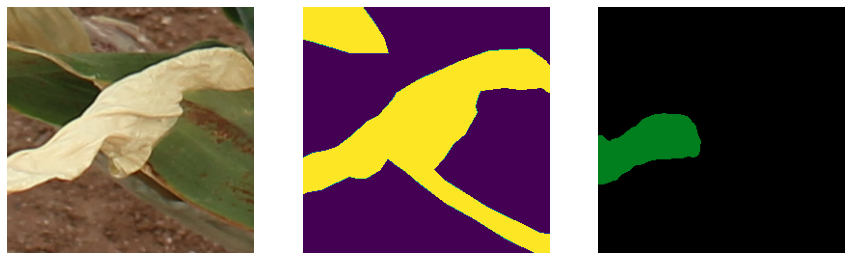

In [ ]:
import matplotlib.pyplot as plt 

ds = SorghumDataset("train")
input_tensor,actual_label = ds[2]
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    mdl.to('cuda')

with torch.no_grad():
    output = mdl.backbone(input_batch)['out'][0]
output_predictions = output.argmax(0)

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_tensor.shape[1:])
r.putpalette(colors)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15,10)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

img = input_tensor.transpose(0,2).transpose(0,1).cpu().detach().numpy().astype('uint8')

ax1.imshow(img)
ax2.imshow(actual_label)
ax3.imshow(r)
